# Praca domowa nr 10 - Wyjaśnialne Uczenie Maszynowe
### Wojciech Celej

In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.metrics import *
from sklearn.model_selection import *
import shap

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import warnings

In [2]:
warnings.filterwarnings('ignore')
seed = 123
num_cpus = 4

### Przygotowanie danych

In [3]:
hcmst = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")
hcmst.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


Do budowy modelu użyto 10 zmiennych
* 5 ilościowych: 
    - `ppage` - age
    - `age_when_met` - age when met in years
    - `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    - `w6_q24_length` - length of q24 how met answer in characters
    - `w6_q16` - how many relatives see in person each month 
* 5 jakościowych (4 pierwsze porządkowe): 
    - `ppp20072` - How often do you attend religious services? 
    - `partyid7` - Political party affiliation (7 categories) 
    - `w6_q12` - partner political affiliation
    - `w6_relationship_quality` - quality of existing relationships based on w6_q34
    - `hcm2017q24_met_online` - met online, all kinds 

In [4]:
features = ["ppage", "age_when_met", "time_from_rel_to_cohab", "w6_q24_length", "w6_q16",
            "ppp20072", "partyid7", "w6_q12", "w6_relationship_quality", "hcm2017q24_met_online",
            "S1"]

In [5]:
myDf = hcmst[features]
myDf = myDf.query("time_from_rel_to_cohab > 0")

In [6]:
myDf["ppp20072"] = myDf["ppp20072"].map({
    "Refused": np.nan, 
    "Never": 0,
    "Once a year or less": 1,
    "A few times a year": 2,
    "Once or twice a month": 3,
    "Once a week": 4,
    "More than once a week": 5,
})

In [7]:
myDf["w6_relationship_quality"] = myDf["w6_relationship_quality"].map({
    "very poor": -2,
    "poor": -1,
    np.nan: 0,
    "fair": 1,
    "good": 2,
    "excellent": 3 
})

In [8]:
parties_dict = {
    "Refused": np.nan,
    "Strong Republican": -3,
    "Not Strong Republican": -2,
    "Leans Republican": -1,
    "Undecided/Independent/Other": 0,
    "Leans Democrat": 1,
    "Not Strong Democrat": 2,
    "Strong Democrat": 3
}
myDf["partyid7"] = myDf["partyid7"].map(parties_dict)
myDf["w6_q12"] = myDf["w6_q12"].map(parties_dict)

In [9]:
myDf["hcm2017q24_met_online"] = myDf["hcm2017q24_met_online"].map({"yes": 1, "no": 0})

In [10]:
myDf["S1"] = myDf["S1"].apply(lambda x: 1 if x.startswith("Yes") else 0).astype(np.int)

In [11]:
columns_mapper = {
    "ppage": "wiek",
    "age_when_met": "wiek kiedy poznano partn.",
    "time_from_rel_to_cohab": "czas od pozn. do zam.",
    "w6_q24_length": "dlugosc odp. jak poznany",
    "w6_q16": "liczba odw. krewnych w mies.",
    "ppp20072": "czestosc praktyk rel.",
    "partyid7": "poglady pol.",
    "w6_q12": "poglady pol. partnera",
    "w6_relationship_quality": "jakosc relacji",
    "hcm2017q24_met_online": "czy poznany online"
}

myDf = myDf.rename(columns=columns_mapper)

### Train test split

In [12]:
myDf = myDf.dropna()
X = myDf.loc[:, myDf.columns!="S1"]
y = myDf.loc[:, "S1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = seed)

### LightGBM

In [13]:
class lgbOptimizer():
    def __init__(self, init_params, X_train, X_test, y_train, y_test, nfolds=5, niters=500, early_stopping_rounds=50):
        self.best_params = init_params
        self.best_num_iters = niters
        self.train_data = lgb.Dataset(data=X_train.values, label=y_train.values)
        self.test_data = lgb.Dataset(data=X_test.values, label=y_test.values)
        self.all_data = lgb.Dataset(data=X_train.append(X_test).values, label=y_train.append(y_test).values)
        self.nfolds = nfolds
        self.niters = niters
        self.early_stopping_rounds = early_stopping_rounds
        
        self.last_results_ = None
        self.last_best_params_ = None
        self.last_best_num_iters_ = None
    
    def set_params(self, params):
        self.best_params.update(params)
    
    def get_params(self):
        return self.best_params.copy()
    
    def evaluate_model_cv(self, eval_step=0):
        cv = lgb.cv(
            params=self.best_params,
            train_set=self.train_data,
            num_boost_round=self.niters, 
            nfold=self.nfolds,
            metrics="auc",
            stratified=True,
            shuffle=True,
            early_stopping_rounds=self.early_stopping_rounds,
            verbose_eval=eval_step
        )
        cv_df = pd.DataFrame(cv)
        cv_best_result = cv_df.iloc[-1,:]
        num_iters = cv_df.shape[0]
        print(f"Best results: {cv_best_result}")
        
    def evaluate_model(self, eval_step=0):
        lgb_classifier = lgb.train(
            {**self.best_params, "num_iterations": self.best_num_iters+200}, 
            train_set=self.train_data,
            early_stopping_rounds=self.early_stopping_rounds,
            valid_sets=self.test_data, 
            verbose_eval=eval_step
        )
        return lgb_classifier
        
    def get_optimal_booster(self, num_iterations=None):
        if num_iterations == None:
            num_iterations = self.best_num_iters
        lgb_classifier = lgb.train(
            {**self.best_params, "num_iterations": num_iterations}, 
            train_set=self.all_data)
        print(f"Model trained. Best params:\n{self.best_params}\nNumber of iterations: {num_iterations}")
        return lgb_classifier
    
    def optimize_model(self, params_dict):
        results = pd.DataFrame(columns=["params", "auc_mean", "auc_std", "num_iters"])
        params_grid = list(ParameterGrid(params_dict))
        for it in tqdm(range(len(params_grid))):
            act_params = self.best_params.copy()
            params = params_grid[it]
            act_params.update(params)
            cv = lgb.cv(
                params=act_params,
                train_set=self.train_data,
                num_boost_round=self.niters, 
                nfold=self.nfolds,
                metrics="auc",
                stratified=True,
                shuffle=True,
                early_stopping_rounds=self.early_stopping_rounds,
                verbose_eval=0
            )
            cv_df = pd.DataFrame(cv)
            cv_best_result = cv_df.iloc[-1,:]
            num_iters = cv_df.shape[0]
            results.loc[it] = [params, cv_best_result["auc-mean"], cv_best_result["auc-stdv"], num_iters]
        
        best = results.sort_values("auc_mean", ascending=False).iloc[0, :]
        auc_mean = best["auc_mean"]
        auc_std = best["auc_std"]
        best_iter = best["num_iters"]
        best_params = best["params"]
        print(f"Best resutlt: auc: {auc_mean} + {auc_std}")
        print(f"Best params: {best_params}\nNum of iterations: {best_iter}")
        self.last_results_ = results
        self.last_best_num_iters_ = best_iter
        self.last_best_params_ = best_params
        return best_params
              
    def update_model(self):
        self.best_params.update(self.last_best_params_)
        self.best_num_iters = self.last_best_num_iters_
        

In [14]:
init_parameters = {
    "objective": "binary",
    "n_jobs": num_cpus,
}

lgb_optimizer = lgbOptimizer(init_parameters, X_train, X_test, y_train, y_test)

### Greedy optimization

In [ ]:
parameters1 = {
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
}
lgb_optimizer.optimize_model(parameters1)

In [ ]:
lgb_optimizer.update_model()

In [ ]:
parameters2 = {
    "max_depth": [8, 10, 15, -1],
    "num_leaves": [20, 31, 40, 50, 75],
    "min_child_weight": [0.01, 0.1, 1, 5, 10, 15, 20],
    "min_child_samples": [10, 15, 20, 30]
}
lgb_optimizer.optimize_model(parameters2)

In [ ]:
lgb_optimizer.update_model()

In [ ]:
parameters3 = {
    "max_bin": [100, 150, 255, 300, 350],
    "bagging_fraction": [0.75, 0.8, 0.9, 1],
    "bagging_freq": [2, 5, 10, 15, 20],
    "feature_fraction": [0.75, 0.8, 0.9, 1],
    "lambda_l2": [0.001, 0.01, 0.1, 1, 10, 100]
}
lgb_optimizer.optimize_model(parameters3)

In [ ]:
lgb_optimizer.update_model()

In [ ]:
parameters4 = {
    "learning_rate": [0.03, 0.04, 0.05],
    "max_depth": [-1, 10, 15],
    "min_child_samples": [12, 15, 18],
    "min_child_weight": [0.8, 1, 1.2],
    "num_leaves": [45, 50, 55],
    "max_bin": [200, 220, 255]
}
lgb_optimizer.optimize_model(parameters4)

In [ ]:
lgb_optimizer.update_model()

In [ ]:
parameters5 = {
    "learning_rate": [0.02, 0.03, 0.04, 0.05],
    "bagging_fraction": [0.6, 0.7, 0.75, 0.8],
    "feature_fraction": [0.6, 0.7, 0.75, 0.8],
    "lambda_l2": [0.05, 0.1, 0.2, 0.5]
}
lgb_optimizer.optimize_model(parameters5)

In [ ]:
lgb_optimizer.update_model()

In [ ]:
lgb_optimizer.get_params()

### Predictions

In [15]:
lgb_optimizer.set_params({'objective': 'binary',
 'n_jobs': 4,
 'learning_rate': 0.03,
 'max_depth': 10,
 'min_child_samples': 15,
 'min_child_weight': 1,
 'num_leaves': 50,
 'bagging_fraction': 0.75,
 'bagging_freq': 15,
 'feature_fraction': 0.8,
 'lambda_l2': 0.5,
 'max_bin': 200})

In [16]:
lgb_classifier = lgb_optimizer.evaluate_model()
y_pred = lgb_classifier.predict(X_test)

### SHAP

In [17]:
shap.initjs()

#### Global explanations

In [35]:
explainer = shap.TreeExplainer(lgb_classifier)
shap_values = explainer.shap_values(X)

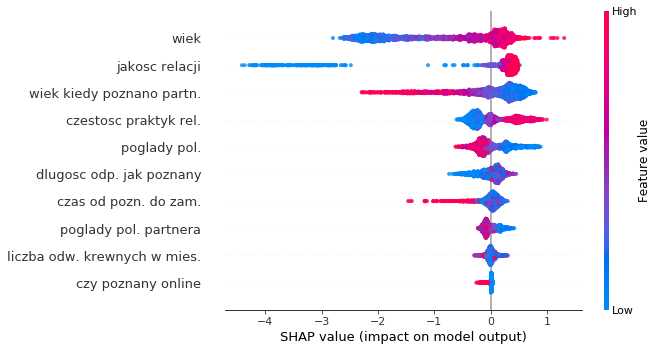

In [46]:
shap.summary_plot(shap_values, X, alpha=0.8)

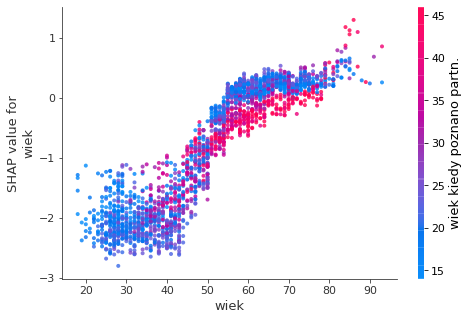

In [67]:
shap.dependence_plot("wiek", shap_values, X, alpha=0.8)

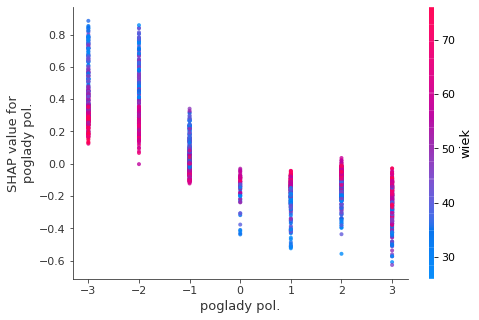

In [70]:
shap.dependence_plot("poglady pol.", shap_values, X, alpha=0.8)#, interaction_index="poglady pol. partnera")

#### Sample explanations

In [73]:
test_set = X_test.copy()
test_set["S1"] = y
test_set["S1_pred"] = y_pred
sorted_test = test_set.sort_values("S1_pred", ascending=False)
X_test_sorted = sorted_test.iloc[:, :-2]

In [76]:
sorted_test.head()

,wiek,wiek kiedy poznano partn.,czas od pozn. do zam.,dlugosc odp. jak poznany,liczba odw. krewnych w mies.,czestosc praktyk rel.,poglady pol.,poglady pol. partnera,jakosc relacji,czy poznany online,S1,S1_pred
1818,56,24.0,2.666626,173.0,0.0,4.0,-3.0,-3.0,3,0,1,0.982131
2129,56,19.0,2.000000,200.0,7.0,4.0,-3.0,-3.0,2,0,1,0.980957
969,52,18.0,1.333374,194.0,7.0,4.0,-2.0,-3.0,3,0,1,0.979535
1071,69,13.0,2.666626,312.0,5.0,4.0,-2.0,-3.0,3,0,1,0.979087
1069,76,18.0,4.000000,206.0,2.0,4.0,-1.0,-1.0,3,0,1,0.978499


In [84]:
hcmst.loc[1818,"ppgender"]

'Male'

In [77]:
sorted_test.tail()

,wiek,wiek kiedy poznano partn.,czas od pozn. do zam.,dlugosc odp. jak poznany,liczba odw. krewnych w mies.,czestosc praktyk rel.,poglady pol.,poglady pol. partnera,jakosc relacji,czy poznany online,S1,S1_pred
2335,46,26.0,1.416626,123.0,3.0,1.0,3.0,1.0,0,0,0,0.063732
757,62,59.0,0.333374,421.0,0.0,0.0,2.0,1.0,0,0,0,0.062237
2261,55,33.0,0.416626,84.0,0.0,0.0,1.0,0.0,0,0,0,0.057279
1347,40,34.0,0.250000,31.0,6.0,0.0,3.0,3.0,0,0,0,0.056746
1503,63,42.0,0.333374,34.0,1.0,1.0,3.0,0.0,0,0,0,0.047753


In [85]:
hcmst.loc[1347, "ppgender"]

'Male'

In [89]:
shap_values_test = explainer.shap_values(X_test_sorted)

In [99]:
shap.force_plot(explainer.expected_value, shap_values_test[0,:], X_test_sorted.iloc[0,:])

In [100]:
shap.force_plot(explainer.expected_value, shap_values[-2,:], X_test_sorted.iloc[-2,:])

In [133]:
def plot_break_down(model, df, sample, features_path):
    sns.set(rc={'figure.figsize':(9,12)})
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.1)
    modDf = df.copy()
    y = model.predict(modDf)
    resultDf = pd.DataFrame(data = {"marriedProb": y, "step": "all data"})
    for feature in features_path:
        value_of_feature = sample[feature]
        modDf[feature] = value_of_feature
        y = model.predict(modDf)
        resultDf = resultDf.append(pd.DataFrame(data = {"marriedProb": y, "step": "+ {} = {:0.2f}".format(feature, value_of_feature)}), ignore_index=True)
    steps = resultDf["step"].unique()[::-1]
    sns.violinplot(data = resultDf,  x="marriedProb", y="step", inner=None, order=steps, color = "white")
    means = []
    for i, step in enumerate(steps):
        mean = resultDf.loc[resultDf["step"]==step].loc[:, "marriedProb"].mean()
        plt.plot(mean, i, "o", color="firebrick", markersize=10)
        plt.text(mean + 0.025, i - 0.15, "{:0.3f}".format(mean))
        means.append(mean)
    for i in range(len(steps)-2, -1, -1):
        diff = means[i]-means[i+1]
        color = "darkgreen" if diff >= 0 else "darkred"
        plt.text(1.1, i, "{:+0.3f}".format(diff), color = color)
    plt.grid(axis="y")
    plt.ylabel("")
    plt.xlabel("")
    plt.xlim(0, 1)

In [134]:
features_path = ["ppage", "age_when_met", "time_from_rel_to_cohab", "w6_q24_length", "w6_q16",
            "ppp20072", "partyid7", "w6_q12", "w6_relationship_quality", "hcm2017q24_met_online"]

In [135]:
columns_mapper.values()

dict_values(['wiek', 'wiek kiedy poznano partn.', 'czas od pozn. do zam.', 'dlugosc odp. jak poznany', 'liczba odw. krewnych w mies.', 'czestosc praktyk rel.', 'poglady pol.', 'poglady pol. partnera', 'jakosc relacji', 'czy poznany online'])

In [142]:
path1 = [
    'wiek kiedy poznano partn.',
    'liczba odw. krewnych w mies.', 
    'czas od pozn. do zam.', 
    'dlugosc odp. jak poznany', 
    'czestosc praktyk rel.', 
    'poglady pol.', 
    'poglady pol. partnera', 
    'czy poznany online',
    'wiek', 
    'jakosc relacji', 
]

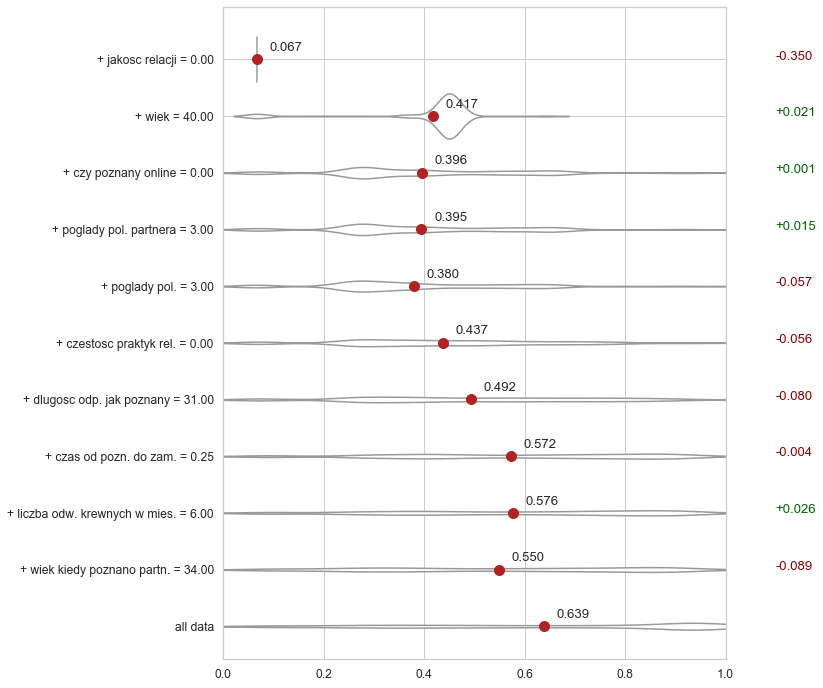

In [145]:
plot_break_down(lgb_classifier, X, X_test_sorted.iloc[-2,:], path1)